# Tutorial

In [1]:
import sys
import os
import time
# Add the path to the parent module
sys.path.append(os.path.abspath('../..'))

In [2]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

from deeppy import LearnFrame, DataGetter, Network, Model



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor
training_data = datasets.MNIST(
    root="datasets",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="datasets",
    train=False,
    download=True,
    transform=ToTensor()
)

X,X_test = training_data.train_data.unsqueeze(1) / 255, test_data.train_data.unsqueeze(1) / 255
y, y_test = training_data.train_labels, test_data.train_labels
batch_size = 128
data = DataGetter(X=X,y=y,X_test = X_test, y_test= y_test, batch_size = batch_size)

data_set_epochs = len(X) / batch_size

/home/boz/anaconda3/envs/deeppy/lib/python3.13/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/boz/anaconda3/envs/deeppy/lib/python3.13/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [4]:
latent_size = 20

kernel = 4
stride = 2
padding = 1

cnn_arch = {
            "layers":[1,32,64],
            "blocks":[nn.Conv2d, nn.ReLU,],
            "block_args": [{"kernel_size" : 3, "stride":1, "padding"  : 1} , {} ],
            "out_act":nn.ReLU,
            "weight_init":"uniform",
}

class Flatten(nn.Module):
    def __init__(self, start_dim: int = 1, end_dim: int = -1) -> None:
        super().__init__()
        self.start_dim = start_dim
        self.end_dim = end_dim

    def forward(self, input):
        return input.flatten(self.start_dim, self.end_dim)

mid_arch = {
    "blocks" : [nn.MaxPool2d, nn.Dropout, Flatten],
    "block_args" : [{"kernel_size":2}, {"p":0.25}]
}



dense_arch = {
    "layers":[64*14*14, 128, 10],
    "blocks":[nn.Linear, nn.ReLU],
    "block_args":[],
    "out_act":nn.Identity,
    "weight_init":"uniform",
}



network_params = [cnn_arch, mid_arch,  dense_arch]


Scheduler_params = {
    "scheduler" : optim.lr_scheduler.StepLR,
    "gamma":0.1**(1/1000),
    "auto_step":False,
    "step_size" : 1
}
Optimizer_params = {
    "optimizer":optim.AdamW,
    "optimizer_args":{"lr" : 1e-3, "amsgrad" : True},
    "clipper":torch.nn.utils.clip_grad_value_,
    "clipper_params":{"clip_value" : 100},
    "scheduler_params":Scheduler_params,
}

network_params = {
    "arch_params" : network_params,  
    "task" :"reg",
    "optimizer_params" : Optimizer_params
}

net = Network(**network_params)
print(net)
print("----------")
X,y = data.train_data()
print(X.shape)

print(f"out shpae : {net(X).shape}")

Network(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Flatten()
    (7): Linear(in_features=12544, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=10, bias=True)
    (10): Identity()
  )
)
----------
torch.Size([128, 1, 28, 28])
out shpae : torch.Size([128, 10])


In [5]:
model_params = {
    "network_params" : network_params,
    "device" : device,
    "criterion" : nn.CrossEntropyLoss()
}


model = Model(**model_params)
#net = Network(**network_params)
#print(net)
#print("----------")
#print(f"out shpae : {net(data.train_data()).shape}")

#model = B_Vae.load("checkpoint/b_vae.pt")

In [6]:
lf = LearnFrame(model, data)

In [7]:
lf.optimize()
lf.test()

TypeError: Model.optimize() takes 2 positional arguments but 3 were given

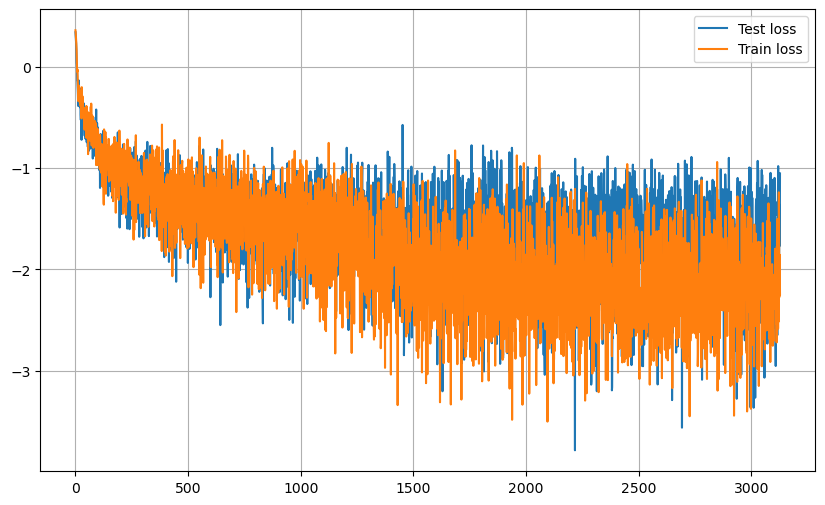

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [55]:
for i in range(3000):
    lf.optimize()
    lf.test()
    if i > 1000:
        lf.scheduler_step()
    if i % 100 ==0:
        plot_data = np.log10(np.stack([lf.test_data, lf.train_data]))
        plot_labels = ["Test loss", "Train loss"]
        lf.plot([plot_data], labels = [plot_labels],show_result= False)
plot_data = np.log10(np.stack([lf.test_data, lf.train_data]))
lf.plot([plot_data], labels = [plot_labels],show_result= True)

In [60]:
lf.model.device

device(type='cuda')

In [63]:
model.device

device(type='cuda')

In [65]:
im.device

device(type='cpu')

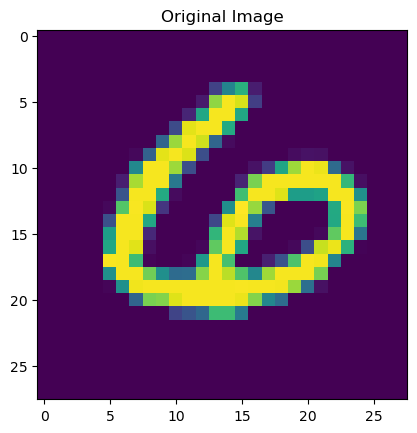

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [68]:
im, _ = data.train_data()
plt.imshow(im[0,0])
plt.title("Original Image")
plt.show()

lf.model.predict(*(im,))

In [59]:
im.shape

torch.Size([128, 1, 28, 28])

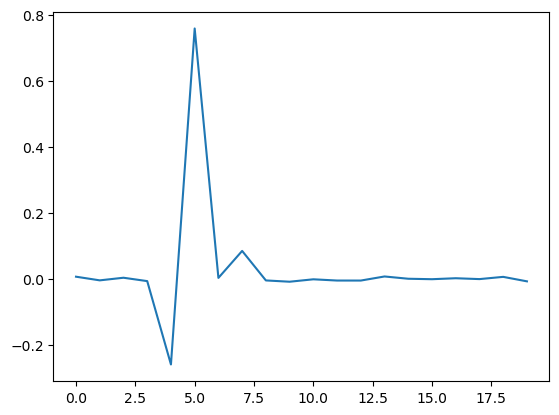

In [100]:
plt.plot(mu[0])

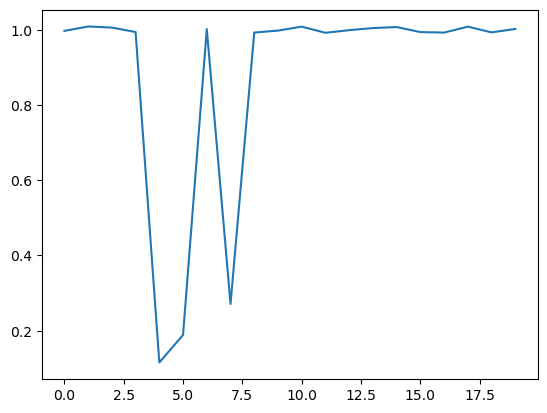

In [101]:
plt.plot(np.exp(log_var[0]))